In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U

  Using cached accelerate-0.30.0-py3-none-any.whl (302 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)


In [7]:
import numpy as np
import pandas as pd
import os

from datasets import load_dataset, DatasetDict, concatenate_datasets

import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

import matplotlib.pyplot as plt

In [8]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [10]:
INPUT_DIR = "./"
OUTPUT_DIR = "./output/xlm-roberta"
CHECKPOINT = "symanto/xlm-roberta-base-snli-mnli-anli-xnli"

In [11]:
# Load data
data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")

data = data.train_test_split(0.2)

translated_data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "translated.csv"), trust_remote_code=True, split="train")

train_data = concatenate_datasets([data['train'], translated_data])
train_data = train_data.shuffle(seed=42)

data = DatasetDict(
    {
        "train": train_data,
        "val": data["test"],
        "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
    }
)
data



# # Load data
# data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")
# data = data.train_test_split(0.2)

# data = DatasetDict(
#     {
#         "train": data["train"],
#         "val": data["test"],
#         "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
#     }
# )

# data

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 105876
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [12]:
df = data["train"].to_pandas()
df.head()

,id,premise,hypothesis,lang_abv,language,label
0,f714ec0aebde,"Als seine Stiefmutter davon erfuhr, machte sie...","Für die letzten Worte, die er vor ihrem Tod zu...",de,German,1
1,e29260de52es,Había recorrido un largo camino con lo que hab...,Aprendió mucho de ese libro de primaria.,es,Spanish,1
2,9b88046c60vi,Cha của đứa bé đã phản ứng bằng cách nộp đơn k...,Mẹ của đứa bé đã phản ứng bằng cách nộp đơn ki...,vi,Vietnamese,2
3,a442fe90batr,Ciltler yeniden mevcut ancak nemli kütüphane y...,Ciltler yenilendikten sonra halkın kullanımına...,tr,Turkish,0
4,b5244abaacur,Ibiza کی لوک داستان,ابیزان لوک داستان تحریری شکل میں دستیاب ہے۔,ur,Urdu,1


In [13]:
df[["premise", "hypothesis", "lang_abv", "language"]].describe()

,premise,hypothesis,lang_abv,language
count,105876,105876,105876,105876
unique,55241,105806,15,15
top,Bauerstein.&quot;,Alfred Inglethorp,zh,Chinese
freq,18,6,7200,7200


In [14]:
df[["lang_abv", "language"]].value_counts()

lang_abv  language  
zh        Chinese       7200
ar        Arabic        7193
fr        French        7187
el        Greek         7174
hi        Hindi         7174
ur        Urdu          7171
vi        Vietnamese    7168
th        Thai          7166
ru        Russian       7164
sw        Swahili       7158
de        German        7156
bg        Bulgarian     7154
es        Spanish       7154
tr        Turkish       7146
en        English       5511
Name: count, dtype: int64

In [15]:
df.isna().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [20]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN3Cls(nn.Module):
    def __init__(self):
        super(CNN3Cls, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=768, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=768, out_channels=512, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# class CNNCls(nn.Module):
#     def __init__(self):
#         super(CNNCls, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.2)
#         self.fc = nn.Linear(256, 3)

#     def forward(self, x):
#         x = x.permute(0, 2, 1)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = x.permute(0, 2, 1)
#         x = x.mean(dim=1)
#         x = self.dropout(x)
#         x = self.fc(x)
#         return x

class LSTMCls(nn.Module):
    def __init__(self):
        super(LSTMCls, self).__init__()
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # LSTM返回两个元组，(output, (h_n, c_n))
        # output: (batch_size, seq_length, num_directions * hidden_size)
        # h_n: (num_layers * num_directions, batch_size, hidden_size)
        # c_n: (num_layers * num_directions, batch_size, hidden_size)
        output, (h_n, c_n) = self.lstm(x)
        x = self.relu(output[:, -1, :])  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class GRUCls(nn.Module):
    def __init__(self):
        super(GRUCls, self).__init__()
        self.gru = nn.GRU(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # GRU的输出 (output, h_n)
        output, h_n = self.gru(x)  # output: (batch_size, seq_length, hidden_size)
        x = self.relu(output[:, -1, :])  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class RNNCls(nn.Module):
    def __init__(self):
        super(RNNCls, self).__init__()
        self.rnn = nn.RNN(
            input_size=768, hidden_size=256, num_layers=1, batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        output, h_n = self.rnn(x) 
        x = output[:, -1, :]
        x = self.relu(x) 
        x = self.dropout(x)
        x = self.fc(x)
        return x

class MultiheadAttentionCls(nn.Module):
    def __init__(self):
        super(MultiheadAttentionCls, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(768, 3)

    def forward(self, x):
        # 假设x的形状是(batch_size, seq_length, embed_dim)
        # 多头注意力需要输入key, query, value，这里我们使用同一个x作为三者
        attn_output, _ = self.attention(x, x, x)
        # 取多头注意力输出的平均或者最后一个时间步的输出
        x = self.relu(attn_output.mean(dim=1))
        x = self.dropout(x)
        x = self.fc(x)
        return x

model.classifier = CNN3Cls()


model



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [22]:
def preprocess_data(batch):
    batch["text"] = [
        x1 + f" {tokenizer.sep_token} " + x2
        for x1, x2 in zip(batch["premise"], batch["hypothesis"])
    ]
    return tokenizer(batch["text"])

data = data.map(preprocess_data, batched=True)
data

Map:   0%|          | 0/105876 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 105876
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'text', 'input_ids', 'attention_mask'],
        num_rows: 5195
    })
})

In [23]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)

train_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "results"),
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    report_to=[],
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    save_steps=200,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=1,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    save_only_model=True,
)

# train_args = TrainingArguments(
#     output_dir=os.path.join(OUTPUT_DIR, "results"),
#     logging_dir=os.path.join(OUTPUT_DIR, "logs"),
#     report_to=[],
#     evaluation_strategy="steps",
#     eval_steps=200,
#     logging_steps=200,
#     save_steps=200,
#     per_device_eval_batch_size=16,
#     per_device_train_batch_size=16,
#     learning_rate=2e-5,
#     weight_decay=0.005,
#     num_train_epochs=5,
#     fp16=True,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     save_total_limit=3,
#     save_only_model=True,
# )

train_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_steps=200,
evaluation_strategy=steps,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_

In [24]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# trainer = Trainer(
#     model=model,
#     args=train_args,
#     data_collator=data_collator,
#     train_dataset=data["train"],
#     eval_dataset=data["val"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(3)],
# )

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,0.675300,0.423090,0.845297
400,0.618000,0.370581,0.855198
600,0.595700,0.347423,0.873350
800,0.580600,0.341449,0.877888
1000,0.588600,0.341651,0.879538
1200,0.550600,0.298192,0.893977
1400,0.536100,0.307916,0.888201
1600,0.508400,0.312744,0.881601
1800,0.519500,0.310133,0.887376
2000,0.502400,0.288585,0.889026


TrainOutput(global_step=6618, training_loss=0.4310606688882477, metrics={'train_runtime': 1837.5655, 'train_samples_per_second': 57.618, 'train_steps_per_second': 3.602, 'total_flos': 5589501936375600.0, 'train_loss': 0.4310606688882477, 'epoch': 1.0})

In [25]:
log = trainer.state.log_history
log

[{'loss': 0.6753,
  'grad_norm': 21.95233917236328,
  'learning_rate': 1.9404653974010276e-05,
  'epoch': 0.030220610456331218,
  'step': 200},
 {'eval_loss': 0.42308980226516724,
  'eval_accuracy': 0.8452970297029703,
  'eval_runtime': 5.017,
  'eval_samples_per_second': 483.162,
  'eval_steps_per_second': 30.297,
  'epoch': 0.030220610456331218,
  'step': 200},
 {'loss': 0.618,
  'grad_norm': 26.703969955444336,
  'learning_rate': 1.8803263825929286e-05,
  'epoch': 0.060441220912662436,
  'step': 400},
 {'eval_loss': 0.3705805540084839,
  'eval_accuracy': 0.8551980198019802,
  'eval_runtime': 4.4557,
  'eval_samples_per_second': 544.021,
  'eval_steps_per_second': 34.114,
  'epoch': 0.060441220912662436,
  'step': 400},
 {'loss': 0.5957,
  'grad_norm': 27.623046875,
  'learning_rate': 1.8198851616802662e-05,
  'epoch': 0.09066183136899365,
  'step': 600},
 {'eval_loss': 0.34742340445518494,
  'eval_accuracy': 0.8733498349834984,
  'eval_runtime': 4.5438,
  'eval_samples_per_second': 

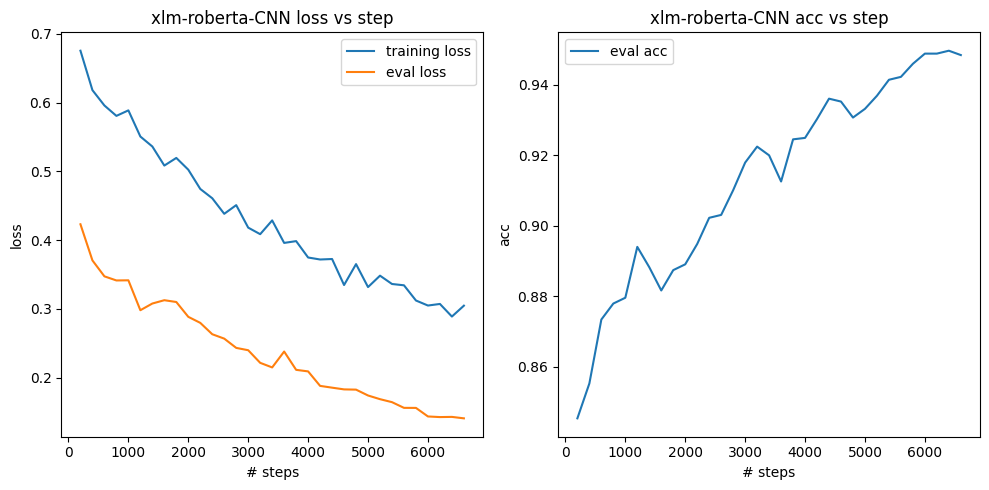

In [29]:
steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log["step"])
    train_loss.append(train_log["loss"])
    eval_loss.append(eval_log["eval_loss"])
    eval_acc.append(eval_log["eval_accuracy"])

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title("xlm-roberta-CNN loss vs step")
plt.xlabel("# steps")
plt.ylabel("loss")
plt.plot(steps, train_loss, label="training loss")
plt.plot(steps, eval_loss, label="eval loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("xlm-roberta-CNN acc vs step")
plt.xlabel("# steps")
plt.ylabel("acc")
plt.plot(steps, eval_acc, label="eval acc")
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
preds = trainer.predict(data["test"])
preds

PredictionOutput(predictions=array([[-1.1650391 , -1.9892578 ,  6.8007812 ],
       [-2.6875    ,  5.1757812 , -1.8408203 ],
       [ 3.6933594 , -1.9355469 , -1.953125  ],
       ...,
       [ 4.109375  , -2.4394531 , -1.9355469 ],
       [ 4.3632812 , -2.7519531 , -1.9267578 ],
       [-2.0683594 , -0.57177734,  6.2226562 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 8.5023, 'test_samples_per_second': 611.014, 'test_steps_per_second': 38.225})

In [28]:
pd.DataFrame(
    {"id": data["test"]["id"], "prediction": np.argmax(preds.predictions, axis=1)}
).to_csv(os.path.join(OUTPUT_DIR, "submission.csv"), header=True, index=False)